# Data Preprocess

In [1]:
#import wandb
#wandb.init(config=args)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models, transforms
from torch.utils.data import DataLoader

%matplotlib inline

In [3]:
# important: It should be defined first, pytorch need to specify device for every tensor
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda:0


In [4]:
import os
from torch.utils.data import Dataset
from PIL import Image


class ImageDataset(Dataset):
    def __init__(self, img_labels, img_dir, transform=None, target_transform=None):
        # storage these params for use in getitem
        self.img_labels = img_labels
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

    
#train_dataset = ImageDataset(train_data[['Id', 'Pawpularity']], '../input/train-after-classification/cats', transform=transforms.ToTensor())
#test_dataset = ImageDataset(test_data[['Id', 'Pawpularity']], '../input/train-after-classification/cats', transform=transforms.ToTensor())

In [5]:
# Comment see image size distribution
# train_dataset = ImageDataset(train_data[['Id', 'Pawpularity']], '../input/petfinder-pawpularity-score/train', transform=transforms.ToTensor())
# 
# sizes = np.array([image.shape for image, _ in train_dataset])
# fig, ax = plt.subplots().
# ax.set_title('Image height, width')
# ax.boxplot(sizes[:, 1:])
# plt.show()

In [6]:
from torchvision import transforms

image_size = 299

# simple transfrom for input X
transform = transforms.Compose([
    transforms.Resize(image_size), 
    transforms.CenterCrop(image_size),
    # require to be tensor for the input of neural net such as resnet18
    transforms.ToTensor(),
    # commonly used normalizer to transfrom 0-255 -> #TODO
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

# transform from 0-100 to 0-1 for label y
def target_transform(y):
    return y/100

def target_inverse_transform(y):
    return y*100

In [7]:
#train_dataset = ImageDataset(train_data[['Id', 'Pawpularity']], '../input/train-after-classification/cats', 
#                             transform=transform, target_transform=target_transform
#                             
#test_dataset = ImageDataset(test_data[['Id', 'Pawpularity']], '../input/train-after-classification/cats',
#                            transform=transform, target_transform=target_transform)

# Model analysis

## Pretained model

In [8]:
def freeze_parameters(model):
    for param in model.parameters():
        param.requires_grad = False

def redefine_last_layer(model):
    num_input_features = model.fc.in_features
    model.fc = nn.Linear(num_input_features, 1)
    
    if hasattr(model, 'AuxLogits'):
        num_aux_input_features = model.AuxLogits.fc.in_features
        model.AuxLogits.fc = nn.Linear(num_aux_input_features, 1)

def get_training_funcs(model):
    # define the loss function for guiding training as binary cross entropy loss
    criterion = nn.BCEWithLogitsLoss()
    # optimizer for training, observe that only parameters of final layer are being optimized.
    optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
    # decay learning rate by a factor of 0.1 every 7 epochs
    learning_rate_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    return criterion, optimizer, learning_rate_scheduler

In [9]:
def train_model(model, dataloader, criterion, optimizer, scheduler, \
                model_name='default', num_epochs=12, is_inception=False):
    model.train() 
    epoches, losses = [], []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            """
            boilerplate code (to(device)), you d better do this
            pytorch need to specify device and need their devices are consistent
            """
            inputs = inputs.to(device)
            labels = torch.reshape(labels, (-1,1)).to(device)
            # boilerplate code (zero_grad), you have to do this, that is a step for pytorch model training
            optimizer.zero_grad()
            if is_inception:
                # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                outputs, aux_outputs = model(inputs)
                loss1 = criterion(outputs, labels)
                loss2 = criterion(aux_outputs, labels)
                loss = loss1 + 0.4*loss2
            else:
                outputs = model(inputs)     
                loss = criterion(outputs, labels)
            # boilerplate code (backward, step), you have to do this, that is a step for pytorch model training
            loss.backward()                    
            optimizer.step() 
            #wandb.log({"loss": loss})
            running_loss += loss.item() * inputs.size(0)
        scheduler.step()

        epoch_loss = running_loss / len(dataloader.dataset)
        epoches.append(epoch)
        losses.append(epoch_loss)
        print('Epoch {}/{}, Loss: {:.4f}'.format(epoch, num_epochs - 1, epoch_loss))
    torch.save(model.state_dict(), '/kaggle/working/' + model_name + '.pth')
    torch.save(model, '/kaggle/working/'+model_name)
    debug_data = (losses, epoches)
    return model, debug_data

In [10]:
def eval_model(model, dataloader, model_path=None):
    if model_path:
        model.load_state_dict(torch.load(model_path))
    model.eval()
    model.to(device)
    predictor = nn.Sigmoid()
    history_se = torch.tensor([]).to(device)

    for x, y in dataloader:
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            y_hat = target_inverse_transform(predictor(model(x))).reshape(1,-1)
        se = (y_hat-y)**2
        rmse = torch.sqrt(torch.mean(se))
        # print(history_se.shape, se.shape)
        history_se = torch.cat((history_se, se.reshape(-1, 1)))
        print('rmse:', rmse)
    rmse = torch.sqrt(torch.mean(history_se))
    print('rmse for whole data:', rmse, ' size of eval data: ', history_se.shape, len(dataloader.dataset))
    return rmse

In [11]:
import matplotlib.pyplot as plt

def loss_graph(losses, epoches):
    plt.plot(epoches, losses)
    plt.title('loss every epoch')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

## CATS TRAIN

In [12]:
df = pd.read_csv("../input/petfinder-pawpularity-score/train.csv")
df["Id"] = df["Id"].apply(lambda x:x+ ".jpg")
cat=pd.DataFrame(os.listdir('../input/train-after-classification/cats'), columns=['Id'])
#dog=pd.DataFrame(os.listdir('../input/train-after-classification/dogs'), columns=['Id'])
#smth=pd.DataFrame(os.listdir('../input/train-after-classification/smth'), columns=['Id'])
cat_labels=df.merge(cat, on='Id', how='inner')
cat_labels.to_csv('cat_labels.csv',encoding='utf-8', index=False)
#dog_labels=df.merge(dog, on='Id', how='inner')
#dog_labels.to_csv('dog_labels.csv',encoding='utf-8', index=False)
#smth_labels=df.merge(smth, on='Id', how='inner')
#smth_labels.to_csv('smth_labels.csv',encoding='utf-8', index=False)


#submission_df = pd.read_csv("../input/petfinder-pawpularity-score/train.csv")

train_data, test_data = np.split(cat_labels, [int(.95*len(cat_labels))])
X_train = train_data.iloc[:, 1:-1]
y_train = train_data.iloc[:, -1]
X_test = test_data.iloc[:, 1:-1]
y_test = test_data.iloc[:, -1]

define common vars

In [13]:
train_subset = ImageDataset(train_data[['Id', 'Pawpularity']], '../input/train-after-classification/cats',
                            transform=transform, target_transform=target_transform)
train_dataloader = DataLoader(train_subset, batch_size=8, shuffle=True, num_workers=2)

eval_dataset = ImageDataset(test_data[['Id', 'Pawpularity']], '../input/train-after-classification/cats',
                            transform=transform)
eval_dataloader = DataLoader(eval_dataset, batch_size=8)
num_epochs = 24

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Epoch 0/23, Loss: 0.6499
Epoch 1/23, Loss: 0.6414
Epoch 2/23, Loss: 0.6419
Epoch 3/23, Loss: 0.6386
Epoch 4/23, Loss: 0.6386
Epoch 5/23, Loss: 0.6362
Epoch 6/23, Loss: 0.6355
Epoch 7/23, Loss: 0.6313
Epoch 8/23, Loss: 0.6317
Epoch 9/23, Loss: 0.6316
Epoch 10/23, Loss: 0.6318
Epoch 11/23, Loss: 0.6318
Epoch 12/23, Loss: 0.6309
Epoch 13/23, Loss: 0.6311
Epoch 14/23, Loss: 0.6314
Epoch 15/23, Loss: 0.6302
Epoch 16/23, Loss: 0.6312
Epoch 17/23, Loss: 0.6295
Epoch 18/23, Loss: 0.6302
Epoch 19/23, Loss: 0.6308
Epoch 20/23, Loss: 0.6312
Epoch 21/23, Loss: 0.6304
Epoch 22/23, Loss: 0.6307
Epoch 23/23, Loss: 0.6304


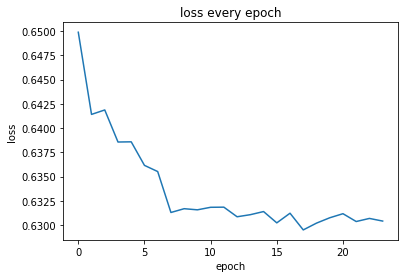

In [14]:
model_conv_cat = models.resnet18(pretrained=True)
#wandb.watch(model_conv, log_freq=100)

freeze_parameters(model_conv_cat)
redefine_last_layer(model_conv_cat)
criterion_conv, optimizer_conv, learning_rate_scheduler_conv = \
    get_training_funcs(model_conv_cat)

model_conv_cat = model_conv_cat.to(device)
model_conv_cat, debug_data_conv_cat = train_model(model_conv_cat, train_dataloader, criterion_conv, optimizer_conv, \
            learning_rate_scheduler_conv, num_epochs=num_epochs, model_name='resnet18_cat')

losses_conv_cat, epoches_conv_cat = debug_data_conv_cat
loss_graph(losses_conv_cat, epoches_conv_cat) 

In [15]:
eval_model(model_conv_cat, eval_dataloader)

rmse: tensor(17.1728, device='cuda:0')
rmse: tensor(18.8296, device='cuda:0')
rmse: tensor(9.2000, device='cuda:0')
rmse: tensor(11.2941, device='cuda:0')
rmse: tensor(15.1209, device='cuda:0')
rmse: tensor(10.6544, device='cuda:0')
rmse: tensor(5.4488, device='cuda:0')
rmse: tensor(12.6405, device='cuda:0')
rmse: tensor(10.2522, device='cuda:0')
rmse: tensor(15.2172, device='cuda:0')
rmse: tensor(9.2437, device='cuda:0')
rmse: tensor(10.4476, device='cuda:0')
rmse: tensor(18.9376, device='cuda:0')
rmse: tensor(13.9380, device='cuda:0')
rmse: tensor(22.1833, device='cuda:0')
rmse: tensor(18.6248, device='cuda:0')
rmse: tensor(16.7284, device='cuda:0')
rmse: tensor(15.6546, device='cuda:0')
rmse for whole data: tensor(14.6009, device='cuda:0')  size of eval data:  torch.Size([143, 1]) 143


tensor(14.6009, device='cuda:0')

## DOG TRAIN

In [16]:
df = pd.read_csv("../input/petfinder-pawpularity-score/train.csv")
df["Id"] = df["Id"].apply(lambda x:x+ ".jpg")
#cat=pd.DataFrame(os.listdir('../input/train-after-classification/cats'), columns=['Id'])
dog=pd.DataFrame(os.listdir('../input/train-after-classification/dogs'), columns=['Id'])
#smth=pd.DataFrame(os.listdir('../input/train-after-classification/smth'), columns=['Id'])
#cat_labels=df.merge(cat, on='Id', how='inner')
#cat_labels.to_csv('cat_labels.csv',encoding='utf-8', index=False)
dog_labels=df.merge(dog, on='Id', how='inner')
dog_labels.to_csv('dog_labels.csv',encoding='utf-8', index=False)
#smth_labels=df.merge(smth, on='Id', how='inner')
#smth_labels.to_csv('smth_labels.csv',encoding='utf-8', index=False)


#submission_df = pd.read_csv("../input/petfinder-pawpularity-score/train.csv")

train_data, test_data = np.split(dog_labels, [int(.95*len(dog_labels))])
X_train = train_data.iloc[:, 1:-1]
y_train = train_data.iloc[:, -1]
X_test = test_data.iloc[:, 1:-1]
y_test = test_data.iloc[:, -1]
print(test_data)

                                        Id  Subject Focus  Eyes  Face  Near  \
4370  f39d0796370bbf60133dbf9f1e86e3cf.jpg              0     1     1     1   
4371  f39e4ffa826f0370b6d9ca392baad06a.jpg              0     1     1     1   
4372  f3ae0533473faff59042902c588adf93.jpg              0     1     1     1   
4373  f3ae3123565f631e19cf3bbdda0f03aa.jpg              0     1     1     1   
4374  f3b15ca931d7283e382af39fb0b385b1.jpg              0     1     1     1   
...                                    ...            ...   ...   ...   ...   
4595  ff76db2a10b7bc5a3217ccb083e87e75.jpg              0     1     1     1   
4596  ff9b3b3468c4b35a3b6450a1ddc88449.jpg              0     1     1     1   
4597  ffcc8532d76436fc79e50eb2e5238e45.jpg              0     1     1     1   
4598  fff19e2ce11718548fa1c5d039a5192a.jpg              0     1     1     1   
4599  fff8e47c766799c9e12f3cb3d66ad228.jpg              0     1     1     1   

      Action  Accessory  Group  Collage  Human  Occ

In [17]:

train_subset = ImageDataset(train_data[['Id', 'Pawpularity']], '../input/train-after-classification/dogs',
                            transform=transform, target_transform=target_transform)
train_dataloader = DataLoader(train_subset, batch_size=8, shuffle=True, num_workers=2)

eval_dataset = ImageDataset(test_data[['Id', 'Pawpularity']], '../input/train-after-classification/dogs',
                            transform=transform)
eval_dataloader = DataLoader(eval_dataset, batch_size=8)
num_epochs = 24

Epoch 0/23, Loss: 0.6793
Epoch 1/23, Loss: 0.6689
Epoch 2/23, Loss: 0.6686
Epoch 3/23, Loss: 0.6687
Epoch 4/23, Loss: 0.6663
Epoch 5/23, Loss: 0.6680
Epoch 6/23, Loss: 0.6680
Epoch 7/23, Loss: 0.6594
Epoch 8/23, Loss: 0.6581
Epoch 9/23, Loss: 0.6571
Epoch 10/23, Loss: 0.6576
Epoch 11/23, Loss: 0.6585
Epoch 12/23, Loss: 0.6577
Epoch 13/23, Loss: 0.6585
Epoch 14/23, Loss: 0.6567
Epoch 15/23, Loss: 0.6567
Epoch 16/23, Loss: 0.6565
Epoch 17/23, Loss: 0.6562
Epoch 18/23, Loss: 0.6566
Epoch 19/23, Loss: 0.6564
Epoch 20/23, Loss: 0.6571
Epoch 21/23, Loss: 0.6569
Epoch 22/23, Loss: 0.6561
Epoch 23/23, Loss: 0.6564


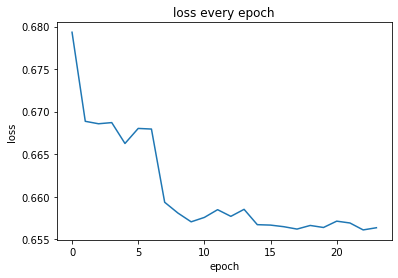

In [18]:
model_conv_dog = models.resnet18(pretrained=True)
#wandb.watch(model_conv, log_freq=100)

freeze_parameters(model_conv_dog)
redefine_last_layer(model_conv_dog)
criterion_conv, optimizer_conv, learning_rate_scheduler_conv = \
    get_training_funcs(model_conv_dog)

model_conv_dog = model_conv_dog.to(device)
model_conv_dog, debug_data_conv_dog = train_model(model_conv_dog, train_dataloader, criterion_conv, optimizer_conv, \
            learning_rate_scheduler_conv, num_epochs=num_epochs, model_name='resnet18_dog')

losses_conv_dog, epoches_conv_dog = debug_data_conv_dog
loss_graph(losses_conv_dog, epoches_conv_dog) 

In [19]:
eval_model(model_conv_dog, eval_dataloader)

rmse: tensor(16.5593, device='cuda:0')
rmse: tensor(19.4338, device='cuda:0')
rmse: tensor(33.8868, device='cuda:0')
rmse: tensor(22.6704, device='cuda:0')
rmse: tensor(18.6358, device='cuda:0')
rmse: tensor(28.1720, device='cuda:0')
rmse: tensor(23.2574, device='cuda:0')
rmse: tensor(12.2040, device='cuda:0')
rmse: tensor(17.6645, device='cuda:0')
rmse: tensor(31.3935, device='cuda:0')
rmse: tensor(22.9048, device='cuda:0')
rmse: tensor(19.6227, device='cuda:0')
rmse: tensor(25.9295, device='cuda:0')
rmse: tensor(14.9422, device='cuda:0')
rmse: tensor(28.4635, device='cuda:0')
rmse: tensor(16.5043, device='cuda:0')
rmse: tensor(20.7638, device='cuda:0')
rmse: tensor(21.3913, device='cuda:0')
rmse: tensor(23.7261, device='cuda:0')
rmse: tensor(15.3275, device='cuda:0')
rmse: tensor(17.6542, device='cuda:0')
rmse: tensor(16.7038, device='cuda:0')
rmse: tensor(17.6404, device='cuda:0')
rmse: tensor(17.9815, device='cuda:0')
rmse: tensor(16.2452, device='cuda:0')
rmse: tensor(20.8864, dev

tensor(21.4105, device='cuda:0')

## SMTH TRAIN

In [20]:
df = pd.read_csv("../input/petfinder-pawpularity-score/train.csv")
df["Id"] = df["Id"].apply(lambda x:x+ ".jpg")
#cat=pd.DataFrame(os.listdir('../input/train-after-classification/cats'), columns=['Id'])
#dog=pd.DataFrame(os.listdir('../input/train-after-classification/dogs'), columns=['Id'])
smth=pd.DataFrame(os.listdir('../input/train-after-classification/smth'), columns=['Id'])
#cat_labels=df.merge(cat, on='Id', how='inner')
#cat_labels.to_csv('cat_labels.csv',encoding='utf-8', index=False)
#dog_labels=df.merge(dog, on='Id', how='inner')
#dog_labels.to_csv('dog_labels.csv',encoding='utf-8', index=False)
smth_labels=df.merge(smth, on='Id', how='inner')
smth_labels.to_csv('smth_labels.csv',encoding='utf-8', index=False)


#submission_df = pd.read_csv("../input/petfinder-pawpularity-score/train.csv")

train_data, test_data = np.split(smth_labels, [int(.95*len(smth_labels))])
X_train = train_data.iloc[:, 1:-1]
y_train = train_data.iloc[:, -1]
X_test = test_data.iloc[:, 1:-1]
y_test = test_data.iloc[:, -1]

In [21]:
train_subset = ImageDataset(train_data[['Id', 'Pawpularity']], '../input/train-after-classification/smth',
                            transform=transform, target_transform=target_transform)
train_dataloader = DataLoader(train_subset, batch_size=8, shuffle=True, num_workers=2)

eval_dataset = ImageDataset(test_data[['Id', 'Pawpularity']], '../input/train-after-classification/smth',
                            transform=transform)
eval_dataloader = DataLoader(eval_dataset, batch_size=8)
num_epochs = 24

Epoch 0/23, Loss: 0.6619
Epoch 1/23, Loss: 0.6514
Epoch 2/23, Loss: 0.6513
Epoch 3/23, Loss: 0.6476
Epoch 4/23, Loss: 0.6466
Epoch 5/23, Loss: 0.6496
Epoch 6/23, Loss: 0.6455
Epoch 7/23, Loss: 0.6410
Epoch 8/23, Loss: 0.6406
Epoch 9/23, Loss: 0.6399
Epoch 10/23, Loss: 0.6404
Epoch 11/23, Loss: 0.6404
Epoch 12/23, Loss: 0.6395
Epoch 13/23, Loss: 0.6412
Epoch 14/23, Loss: 0.6396
Epoch 15/23, Loss: 0.6399
Epoch 16/23, Loss: 0.6393
Epoch 17/23, Loss: 0.6395
Epoch 18/23, Loss: 0.6395
Epoch 19/23, Loss: 0.6398
Epoch 20/23, Loss: 0.6404
Epoch 21/23, Loss: 0.6403
Epoch 22/23, Loss: 0.6397
Epoch 23/23, Loss: 0.6395


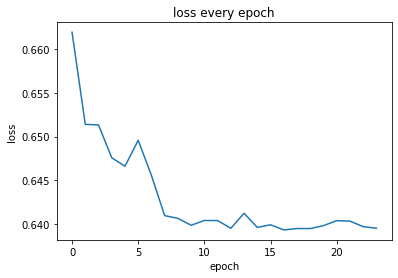

In [22]:
model_conv_smth = models.resnet18(pretrained=True)
#wandb.watch(model_conv, log_freq=100)

freeze_parameters(model_conv_smth)
redefine_last_layer(model_conv_smth)
criterion_conv, optimizer_conv, learning_rate_scheduler_conv = \
    get_training_funcs(model_conv_smth)

model_conv_smth = model_conv_smth.to(device)
model_conv_smth, debug_data_conv_smth = train_model(model_conv_smth, train_dataloader, criterion_conv, optimizer_conv, \
            learning_rate_scheduler_conv, num_epochs=num_epochs, model_name='resnet18_smth')

losses_conv_smth, epoches_conv_smth = debug_data_conv_smth
loss_graph(losses_conv_smth, epoches_conv_smth) 

In [23]:
eval_model(model_conv_smth, eval_dataloader)

rmse: tensor(9.1905, device='cuda:0')
rmse: tensor(12.5350, device='cuda:0')
rmse: tensor(19.6428, device='cuda:0')
rmse: tensor(12.4162, device='cuda:0')
rmse: tensor(15.5774, device='cuda:0')
rmse: tensor(24.0458, device='cuda:0')
rmse: tensor(14.0892, device='cuda:0')
rmse: tensor(13.9379, device='cuda:0')
rmse: tensor(10.8341, device='cuda:0')
rmse: tensor(13.2159, device='cuda:0')
rmse: tensor(22.2745, device='cuda:0')
rmse: tensor(17.3318, device='cuda:0')
rmse: tensor(14.3806, device='cuda:0')
rmse: tensor(13.9632, device='cuda:0')
rmse: tensor(19.6937, device='cuda:0')
rmse: tensor(16.3267, device='cuda:0')
rmse for whole data: tensor(16.0778, device='cuda:0')  size of eval data:  torch.Size([124, 1]) 124


tensor(16.0778, device='cuda:0')

## Submission 

In [24]:
from PIL import Image
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.applications.resnet import preprocess_input as resnet_preprocessing_input
import torch

In [25]:
ResNet50_model = ResNet50(weights='imagenet')

2022-02-02 21:21:28.248324: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-02 21:21:28.250434: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-02 21:21:28.251738: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-02 21:21:28.253221: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

102981632/102967424 [==============================] - 1s 0us/step


In [26]:
ResNet50_model.save('/kaggle/working/ResNet50_model/')

2022-02-02 21:21:41.391078: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [27]:
test_dir = '../input/petfinder-pawpularity-score/test'
test_df = pd.read_csv('../input/petfinder-pawpularity-score/test.csv')
result = []
predictor = nn.Sigmoid()
for image_id in test_df.iloc[:, 0]:
    img_path = os.path.join(test_dir, image_id)
    image = Image.open(img_path + '.jpg') # read_image
    img=image.resize((224, 224), Image.ANTIALIAS)
    converted_image = img_to_array(img)
    reshaped_image = converted_image.reshape((1, converted_image.shape[0], converted_image.shape[1], converted_image.shape[2]))
    resnet_preprocessed_image = resnet_preprocessing_input(reshaped_image)
    probs= ResNet50_model.predict(resnet_preprocessed_image)
    position_of_max = np.argmax(probs)
    print(position_of_max)
    if ((position_of_max >= 151) & (position_of_max <= 268)):
        transformed = transform(image)
        transformed = transformed.reshape(1, transformed.shape[0], transformed.shape[1], transformed.shape[2]).to(device)
        output=model_conv_dog(transformed)        
    elif ((position_of_max >= 281) & (position_of_max <= 285)):
        transformed = transform(image)
        transformed = transformed.reshape(1, transformed.shape[0], transformed.shape[1], transformed.shape[2]).to(device)
        output = model_conv_cat(transformed)
    else:
        transformed = transform(image)
        transformed = transformed.reshape(1, transformed.shape[0], transformed.shape[1], transformed.shape[2]).to(device)
        print(transformed.shape)
        output = model_conv_smth(transformed)
    pred = target_inverse_transform(predictor(output))
    result.append(pred)
    print(result)
        
result_df = pd.DataFrame({'Id': test_df.iloc[:, 0], 'Pawpularity': result})
result_df.to_csv( 'ann_submission.csv', sep='\t')

2022-02-02 21:21:56.890583: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-02 21:21:57.907393: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


411
torch.Size([1, 3, 299, 299])
[tensor([[31.0750]], device='cuda:0', grad_fn=<MulBackward0>)]
411
torch.Size([1, 3, 299, 299])
[tensor([[31.0750]], device='cuda:0', grad_fn=<MulBackward0>), tensor([[29.7324]], device='cuda:0', grad_fn=<MulBackward0>)]
411
torch.Size([1, 3, 299, 299])
[tensor([[31.0750]], device='cuda:0', grad_fn=<MulBackward0>), tensor([[29.7324]], device='cuda:0', grad_fn=<MulBackward0>), tensor([[29.8152]], device='cuda:0', grad_fn=<MulBackward0>)]
574
torch.Size([1, 3, 299, 299])
[tensor([[31.0750]], device='cuda:0', grad_fn=<MulBackward0>), tensor([[29.7324]], device='cuda:0', grad_fn=<MulBackward0>), tensor([[29.8152]], device='cuda:0', grad_fn=<MulBackward0>), tensor([[27.4476]], device='cuda:0', grad_fn=<MulBackward0>)]
792
torch.Size([1, 3, 299, 299])
[tensor([[31.0750]], device='cuda:0', grad_fn=<MulBackward0>), tensor([[29.7324]], device='cuda:0', grad_fn=<MulBackward0>), tensor([[29.8152]], device='cuda:0', grad_fn=<MulBackward0>), tensor([[27.4476]], devi

# TODO

* modify model (ref: https://discuss.pytorch.org/t/how-to-replace-a-layer-or-module-in-a-pretrained-network/60068)
* select model params (ref: https://stackoverflow.com/questions/52548174/how-to-remove-the-last-fc-layer-from-a-resnet-model-in-pytorch )
* improve inception net (https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958)